In [5]:


import networkx as nx
import pandas
from tqdm import trange, tqdm
import clustering
import graph_generator

In [13]:
cities = {
        'ASHA': 'R13470549',
        'KRG': 'R4676636',
        'EKB': 'R6564910',
        'BARCELONA': 'R347950',
        'PARIS': 'R71525',
        'Prague': 'R435514',
        'MSK': 'R2555133',
        'SBP': 'R337422',
        'SINGAPORE': 'R17140517',
        'BERLIN': 'R62422',
        'ROME': 'R41485',
        'LA': 'R207359',
        'DUBAI': 'R4479752',
        'RIO': 'R2697338',
        'DELHI': 'R1942586',
        'KAIR': 'R5466227'
    }
G = graph_generator.get_graph('R6564910')
Q = nx.Graph()
for u, d in G.nodes(data=True):
    Q.add_node(u, x=d['x'], y=d['y'])
for u, v, d in G.edges(data=True):
    if u != v:
        Q.add_edge(u, v, length=d['length'])
del G
G = Q


In [14]:
communities = clustering.LouvainKMeansCommunitiesResolver(resolution=10).find_communities(G)
clustering.CommunitiesResolver.write_communities(G, communities)
cls2hubs = graph_generator.get_cluster_to_bridge_points(G)
cls2n = graph_generator.get_cluster_to_neighboring_clusters(G)

r: 10 length


In [7]:
def get_statistic_per_point(c_from,c_to,cls2hubs, log = False):
    # nodes_from =[u for u in nx.barycenter(extract_cluster_list_subgraph(G, [c_from], communities), weight='length')]
    # nodes_to = [u for u in  nx.barycenter(extract_cluster_list_subgraph(G, [c_to], communities), weight='length')]
    nodes_from = cls2hubs[c_from]
    nodes_to = cls2hubs[c_to]
    statistic = {}
    generator = tqdm(nodes_from, desc='find statistic') if log else nodes_from 
    # generator = [nx.barycenter(extract_cluster_list_subgraph(G, [c_from], communities))[0]]
    for f in generator:
        statistic[f] = {}
        for t in nodes_to:
            p = nx.single_source_dijkstra(G, f,t,weight='length')
            cls = list(dict.fromkeys([int(G.nodes[u]['cluster']) for u in p[1]])) 
            cls = tuple(cls)
            if cls not in statistic[f]:
                statistic[f][cls] = 0
            statistic[f][cls] += 1
    return statistic

In [15]:
A = {}
for i in trange(0,len(communities)):
    A[i] = {}
    for j in cls2n[i]:
        data = get_statistic_per_point(i,j,cls2hubs,False)
        ss= set()
        for k,v in data.items():
            for kk, vv in v.items():
                ss.add(kk)
        cls0to1 = set()
        for ii in ss:
            for jj in ii:
                cls0to1.add(jj)
        A[i][j] = cls0to1

100%|██████████| 329/329 [00:09<00:00, 33.04it/s] 


In [16]:
count_data = {}
for i in A:
    for j in A[i]:
        l = len(A[i][j])
        if l not in count_data:
            count_data[l] = 0
        count_data[l]+=1
        # if len(A[i][j]) > 2:
            # print(i,j,A[i][j])
print(count_data)

{4: 198, 3: 278, 5: 82, 2: 422, 6: 68, 9: 8, 7: 18, 8: 4, 11: 2, 12: 2}


In [17]:
data = {'n' : [k for k in count_data],
        'count': [count_data[k]/2 for k in count_data]}
df = pandas.DataFrame.from_dict(data)

In [18]:
df

,n,count
0,4,99.0
1,3,139.0
2,5,41.0
3,2,211.0
4,6,34.0
5,9,4.0
6,7,9.0
7,8,2.0
8,11,1.0
9,12,1.0


In [24]:
def extract_cluster_list_subgraph(graph: nx.Graph, cluster_number: list[int] | set[int], communities=None) -> nx.Graph:
    if communities:
        nodes_to_keep = [u for c in cluster_number for u in communities[c]]
    else:
        nodes_to_keep = [node for node, data in graph.nodes(data=True) if data['cluster'] in cluster_number]
    return  nx.Graph(graph.subgraph(nodes_to_keep))

In [28]:
H = nx.Graph()
for i,c in enumerate(communities):    
    u  =nx.barycenter(extract_cluster_list_subgraph(G, [i]))[0]
    H.add_node(i, x = G.nodes[u]['x'],y = G.nodes[u]['y'])
for i,c in enumerate(communities):
    for j in cls2n[i]:
        H.add_edge(i,j)

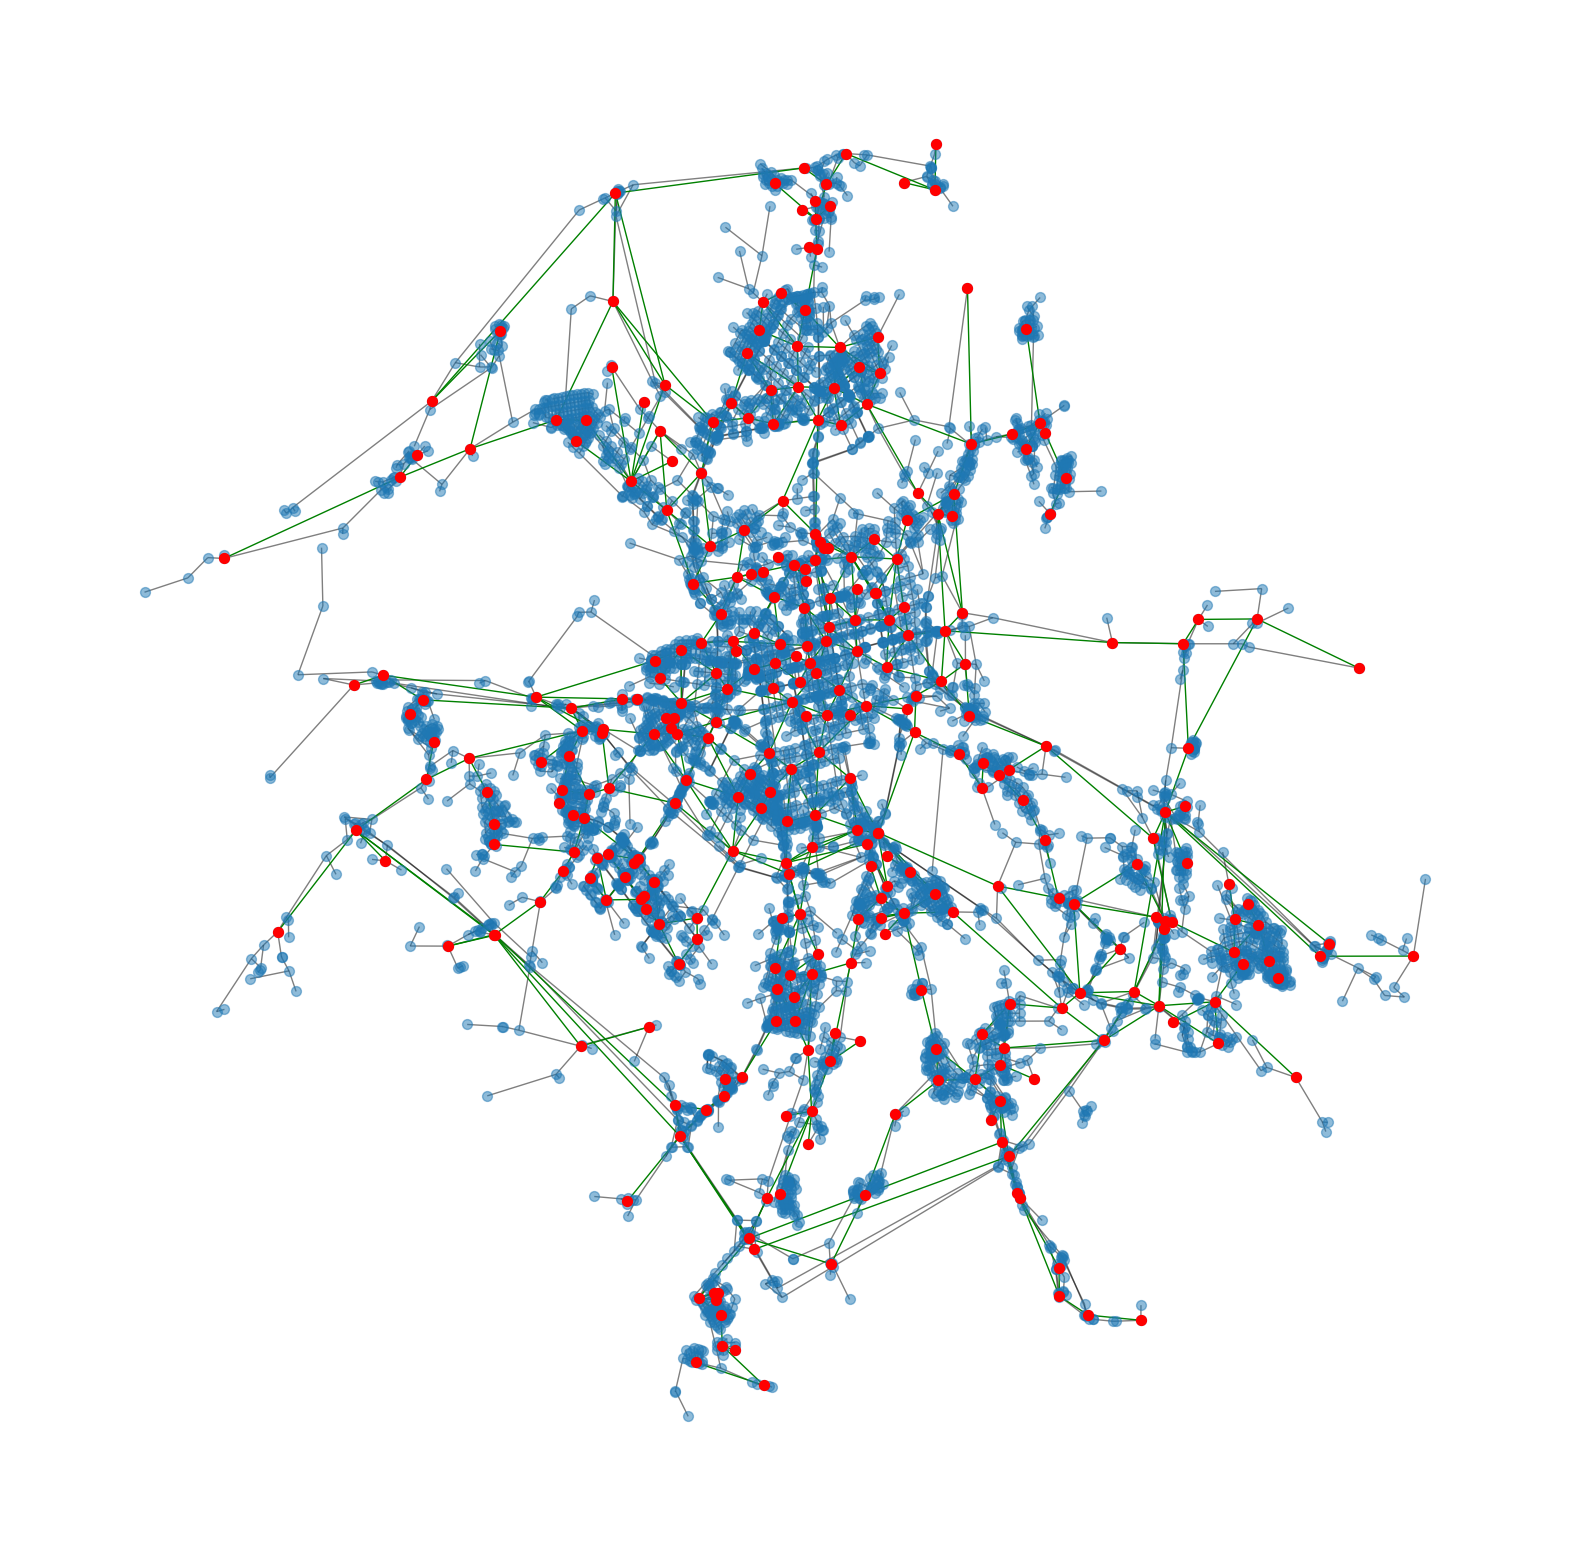

In [45]:
from matplotlib import pyplot as plt

pos_H = {u: (d['x'], d['y']) for u, d in H.nodes(data=True)}
pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}

fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)

nx.draw(G, ax=axs, node_size = 50, pos=pos_G, alpha = 0.5)
nx.draw(H, ax=axs,node_size = 50, pos=pos_H, node_color = 'red', edge_color = 'green')

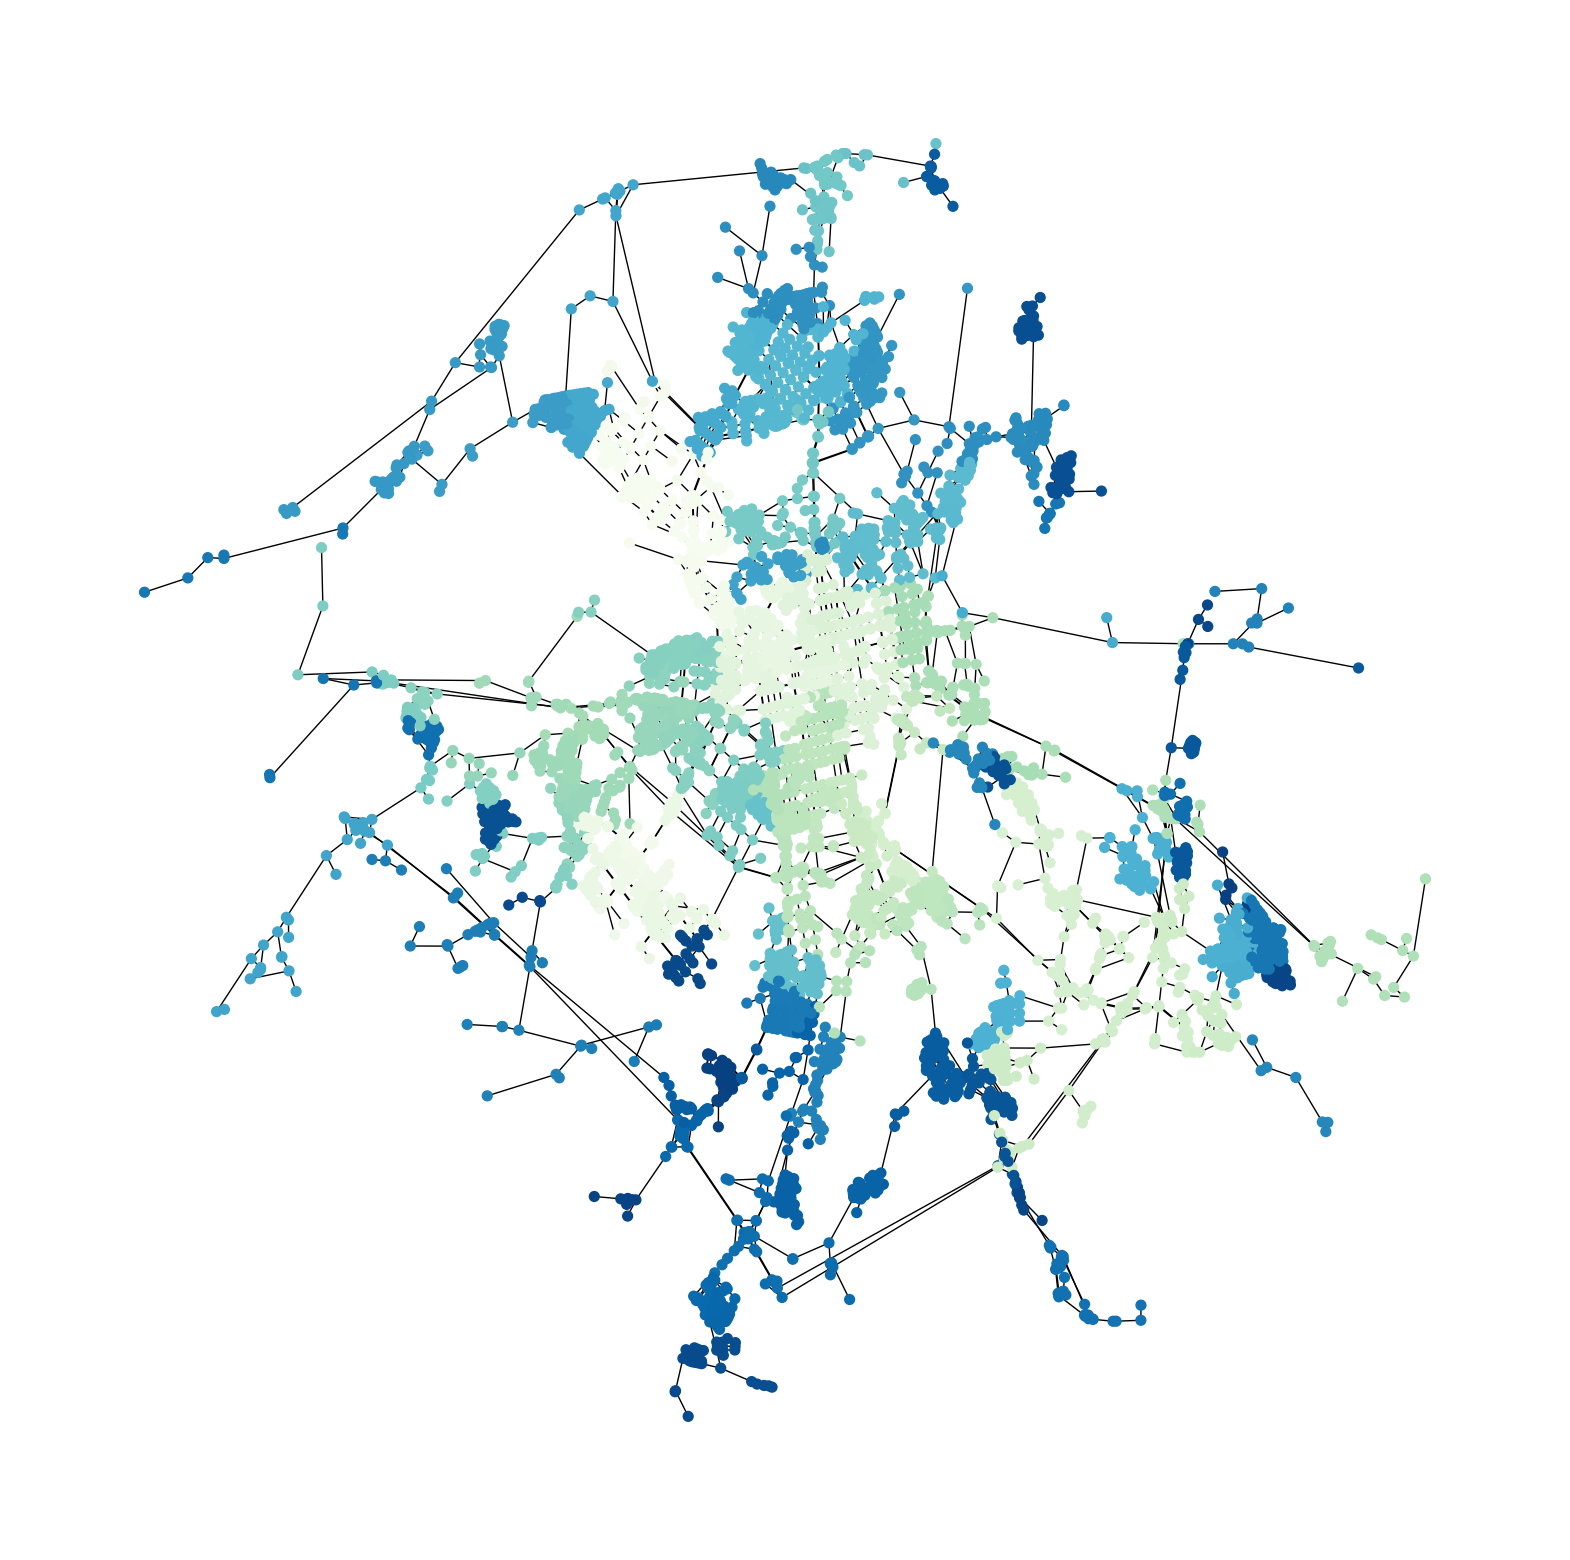

In [78]:
pos_G = {u: (d['x'], d['y']) for u, d in G.nodes(data=True)}
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(20)
cmap = plt.get_cmap('GnBu')
colors = [cmap(d['cluster']/len(communities)) for u,d in G.nodes(data=True)]
nx.draw(G, ax=axs, node_size = 50, pos=pos_G, node_color = colors)

(0.2, 0.6274509803921569, 0.17254901960784313, 1.0)

In [49]:
data = {
    len(cls2hubs[u]) : 0 for u in cls2hubs
}
for u in cls2hubs:
    data[len(cls2hubs[u])] +=1   

df = pandas.DataFrame.from_dict({'hubs' : [k for k in data],
        'count': [data[k] for k in data]})
df

,hubs,count
0,3,29
1,2,30
2,15,5
3,14,6
4,9,19
5,7,20
6,8,20
7,11,16
8,17,1
9,16,5


In [50]:
M = 0
for h in data:
    M += data[h] * h * (h-1)/2
print(M)

7064.0


In [51]:
print(len(G.edges))

7712


5
8
4
4
4
4
1
3
1
1


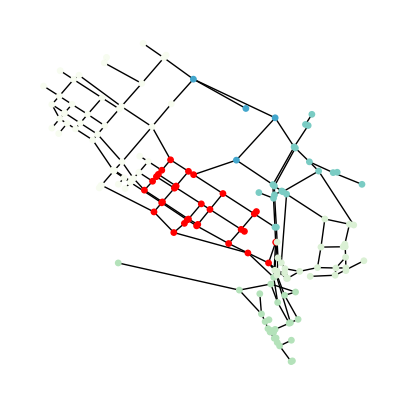

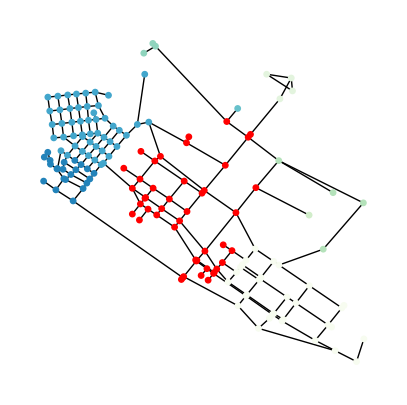

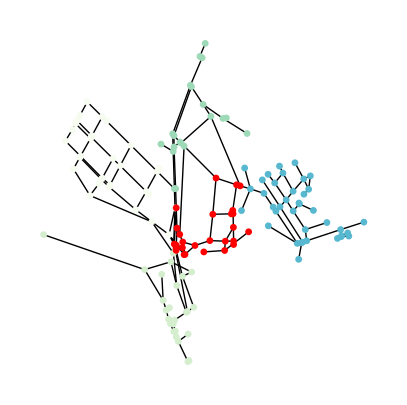

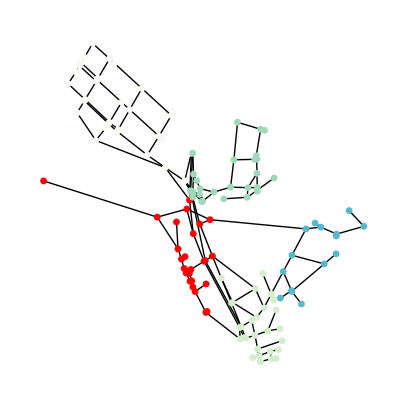

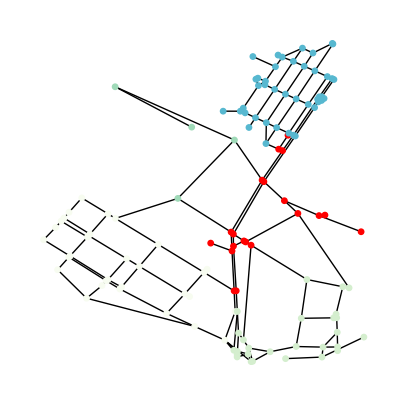

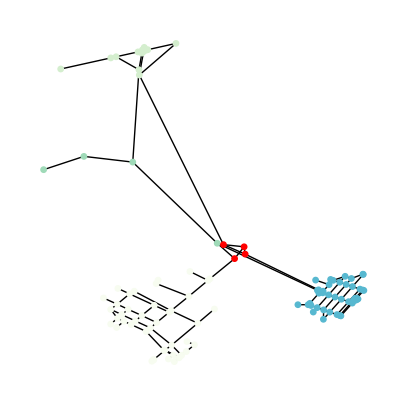

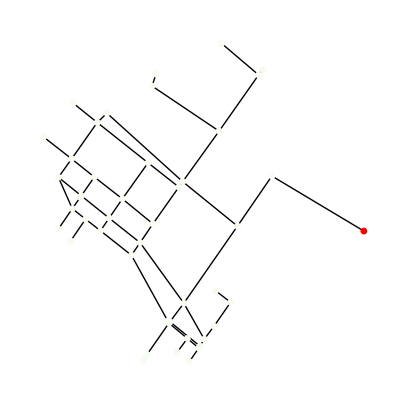

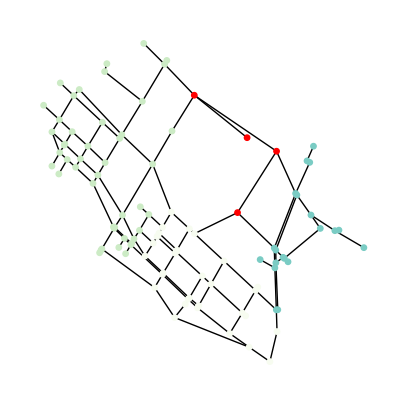

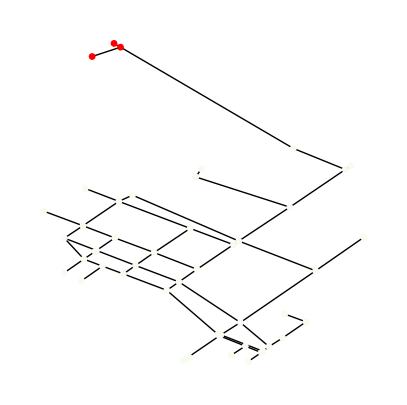

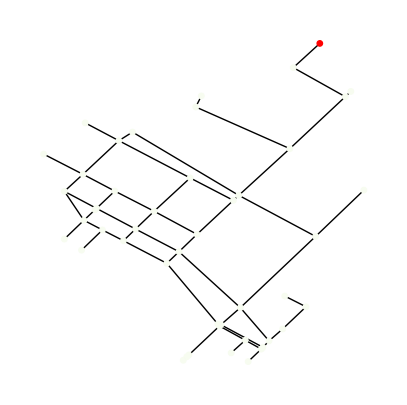

In [82]:
from matplotlib import pyplot as plt
for i in range(10):
    idx = {n : 0for n in cls2n[i]}
    idx[i] = 0
    k = 0
    for n in idx:
        idx[n]=k
        k+=1
    
    S = extract_cluster_list_subgraph(G, set([i]).union(cls2n[i]), communities)
    colors = [cmap(idx[d['cluster']]/k) if d['cluster']!=i else 'red' for u,d in S.nodes(data=True)]
    pos_S = {u: (d['x'], d['y']) for u, d in S.nodes(data=True)}
    fig, axs = plt.subplots(1, 1)
    fig.set_figwidth(5)
    fig.set_figheight(5)
    print(len(cls2n[i]))
    nx.draw(S, ax=axs, node_size = 15, pos=pos_S, node_color =colors)